# Plot analysis of multidecadal variability

CM2-025

Also calculates time series

In [1]:
import intake
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cmocean as cm
import cosima_cookbook as cc

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39495,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:46577,Total threads: 1
Dashboard: /proxy/34645/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:41303,


#### Define a few things first

In [3]:
# Path to data
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'
path_to_data_cz861 = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025_cz861/'

In [4]:
# Plotting info
ft_size = 12
plt.rcParams.update({'font.size': ft_size})
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

In [5]:
# Define colours
CLEX_Red = '#DA1E48'
CLEX_Pink = '#F48580'
CLEX_SkyBlue = '#00BDF2'
CLEX_MidBlue = '#008DD0'
CLEX_CobaldBlue = '#0066B3'
CLEX_MidnightBlue = '#113559'
CLEX_Gray = '#4D4D47'

CLEX_Yellow = '#D9B252'

In [6]:
cat = intake.open_esm_datastore(
    "/g/data/lg87/wgh581/datastore_ACCESS_CM2_025_cz861.json",
    columns_with_iterables=["variable"] # This is important
)

In [7]:
cat_CT = intake.open_esm_datastore(
    "/g/data/lg87/wgh581/experiment-datastore-CT.json",
    columns_with_iterables=["variable"] # This is important
)

In [6]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'
path_to_data_cz861 = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025_cz861/'

### SST time series, North Atlantic

NA defined following Van Oldenborge 2009 as: 25 to 60N and -75 to -7E.

In [9]:
temp = cat.search(variable="temp",frequency="1mon").to_dask()

In [ ]:
lat_slice = slice(25,60) # Van Oldenborgh 2009
lon_slice = slice(-75,-7)

In [10]:
sst_NA = temp.temp.sel(st_ocean=0, method="nearest").sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice) - 273.15

In [16]:
%%time
sst_NA_1 = sst_NA.sel(time=slice('0000-01-01','0099-12-31')).resample(time='YE').mean().load()

CPU times: user 50.9 s, sys: 4.02 s, total: 54.9 s
Wall time: 5min 21s


In [17]:
sst_NA_1.to_netcdf(path_to_data_cz861 + 'SST_NA_annual_cz861_000_099.nc')

In [19]:
%%time
sst_NA_2 = sst_NA.sel(time=slice('0100-01-01','0199-12-31')).resample(time='YE').mean().load()

CPU times: user 54.2 s, sys: 4.08 s, total: 58.3 s
Wall time: 5min 40s


In [20]:
sst_NA_2.to_netcdf(path_to_data_cz861 + 'SST_NA_annual_cz861_100_199.nc')

In [21]:
%%time
sst_NA_3 = sst_NA.sel(time=slice('0200-01-01','0299-12-31')).resample(time='YE').mean().load()

CPU times: user 54.6 s, sys: 3.58 s, total: 58.2 s
Wall time: 5min 29s


In [22]:
sst_NA_3.to_netcdf(path_to_data_cz861 + 'SST_NA_annual_cz861_200_299.nc')

In [23]:
%%time
sst_NA_4 = sst_NA.sel(time=slice('0300-01-01','0399-12-31')).resample(time='YE').mean().load()

CPU times: user 54 s, sys: 4.01 s, total: 58 s
Wall time: 5min 23s


In [24]:
sst_NA_4.to_netcdf(path_to_data_cz861 + 'SST_NA_annual_cz861_300_399.nc')

In [25]:
%%time
sst_NA_5 = sst_NA.sel(time=slice('0400-01-01','0499-12-31')).resample(time='YE').mean().load()

CPU times: user 54 s, sys: 3.94 s, total: 58 s
Wall time: 5min 23s


In [26]:
sst_NA_5.to_netcdf(path_to_data_cz861 + 'SST_NA_annual_cz861_400_499.nc')

Concatenate time series

In [27]:
sst_NA = xr.concat([sst_NA_1, sst_NA_2, sst_NA_3, sst_NA_4, sst_NA_5], dim='time', coords='all')

Detrend time series

In [30]:
# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [32]:
sst_NA_detrend = detrend_dim(sst_NA, 'time')

Rolling mean

In [36]:
data_rolling = sst_NA_detrend.rolling(time=30, center=True).mean('time')

In [43]:
data_rolling_mean = data_rolling.mean('xt_ocean').mean('yt_ocean')

Std of rolling mean

In [74]:
data_rolling_std = data_rolling_mean.std()
data_std = sst_NA_detrend.mean('xt_ocean').mean('yt_ocean').std()

Plot SST of North Atlantic

In [72]:
year = np.arange(1, 500, 1)

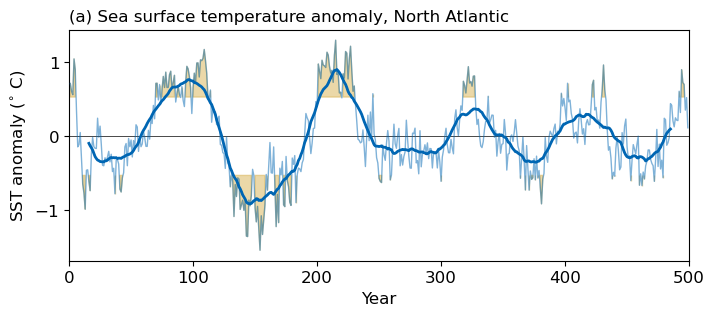

In [75]:
fig = plt.figure(figsize=(8,3))
plt.axhline(0, color='k', linewidth=0.5)

plt.plot(year, sst_NA_detrend.mean('xt_ocean').mean('yt_ocean'), color=CLEX_CobaldBlue, zorder=3, linewidth=1, alpha=0.5)
plt.plot(year, data_rolling_mean, color=CLEX_CobaldBlue, zorder=3, linewidth=1, alpha=0.5)

plt.plot(year, data_rolling.mean('xt_ocean').mean('yt_ocean'), linewidth=2, color=CLEX_CobaldBlue)
# plt.fill_between(year, data_rolling_std, data_rolling_mean, where=data_rolling_mean>data_rolling_std, alpha=0.5, color=CLEX_Yellow)
# plt.fill_between(year, -data_rolling_std, data_rolling_mean, where=data_rolling_mean<-data_rolling_std, alpha=0.5, color=CLEX_Yellow)
plt.fill_between(year, data_std, sst_NA_detrend.mean('xt_ocean').mean('yt_ocean'), where=sst_NA_detrend.mean('xt_ocean').mean('yt_ocean')>data_std, alpha=0.5, color=CLEX_Yellow)
plt.fill_between(year, -data_std, sst_NA_detrend.mean('xt_ocean').mean('yt_ocean'), where=sst_NA_detrend.mean('xt_ocean').mean('yt_ocean')<-data_std, alpha=0.5, color=CLEX_Yellow)

plt.title('(a) Sea surface temperature anomaly, North Atlantic', loc='left', fontsize=ft_size)
plt.xlim(0, 500)
plt.xlabel('Year')
plt.ylabel('SST anomaly ($^{\circ}$ C)');

### AMOC 

26 North

In [ ]:
amoc_26N = xr.open_dataarray(path_to_data_cz861 + 'overturning_26N_CM2_025_001_499_cz861.nc')

In [268]:
amoc_26N_rolling = amoc_26N.rolling(time=30, center=True).mean('time')

In [274]:
print(amoc_26N_rolling.max().values)
print(amoc_26N_rolling.min().values)

18.09671974182129
14.114192008972168


### Select years for composites

Years when SST is in 1$\sigma$ environment -> use for composite plots

In [76]:
year_pos_amo_rolling = sst_NA_detrend.time.where(sst_NA_detrend.mean('xt_ocean').mean('yt_ocean') > data_std).dropna(dim='time')
year_neg_amo_rolling = sst_NA_detrend.time.where(sst_NA_detrend.mean('xt_ocean').mean('yt_ocean') <- data_std).dropna(dim='time')

In [83]:
years_pos_anomaly = year_pos_amo_rolling.dt.year - 1

In [84]:
years_neg_anomaly = year_neg_amo_rolling.dt.year - 1

#### Select years for SST in North Atlantic

In [91]:
#sst_pos = sst_NA[years_pos_anomaly,...].mean('time')

In [101]:
# lon_slice = slice(-75,25)
# lat_slice = slice(40,90)

# lat_slice = slice(25,60) # Van Oldenborgh 2009
# lon_slice = slice(-75,-7)

lat_slice = slice(40,80)
lon_slice = slice(-75,25)

In [102]:
test = temp.temp.sel(st_ocean=0, method="nearest").sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice) - 273.15

In [118]:
test = test.resample(time='YE').mean()

In [122]:
sst_pos = test.sel(time=year_pos_amo_rolling).mean('time').load()

In [123]:
sst_pos.to_netcdf(path_to_data_cz861 + 'sst_pos_composite_cz861.nc')

In [125]:
%%time
sst_neg = test.sel(time=year_neg_amo_rolling).mean('time').load()

CPU times: user 58.8 s, sys: 5.29 s, total: 1min 4s
Wall time: 7min 26s


In [126]:
sst_neg.to_netcdf(path_to_data_cz861 + 'sst_neg_composite_cz861.nc')

#### Select mld (March)

In [159]:
mld = cat.search(variable="mld",frequency="1mon").to_dask()

In [196]:
mld_mar = mld.mld.groupby('time.month')[3]
mld_mar = mld_mar.sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice)

In [199]:
mld_mar_pos = mld_mar[years_pos_anomaly.values,...].mean('time').compute()

In [200]:
mld_mar_neg = mld_mar[years_neg_anomaly.values,...].mean('time').compute()

#### Select sea ice (March)

In [228]:
%%time
aice_mar_5 = cat_CT.search(variable="aice", frequency="1mon", start_date="^04.*.-03").to_dask(xarray_open_kwargs={"use_cftime":True})

CPU times: user 14.4 s, sys: 3.38 s, total: 17.8 s
Wall time: 1min 43s


Adjust time (to ensure it is in the correct month)

In [ ]:
from datetime import timedelta

In [218]:
aice_mar['time'] = aice_mar.time.to_pandas() - timedelta(hours = 12)

In [235]:
aice_mar_1 = aice_mar

In [222]:
aice_mar_2['time'] = aice_mar_2.time.to_pandas() - timedelta(hours = 12)

In [225]:
aice_mar_3['time'] = aice_mar_3.time.to_pandas() - timedelta(hours = 12)

In [227]:
aice_mar_4['time'] = aice_mar_4.time.to_pandas() - timedelta(hours = 12)

In [229]:
aice_mar_5['time'] = aice_mar_5.time.to_pandas() - timedelta(hours = 12)

Concatenate

In [236]:
aice_mar_all = xr.concat([aice_mar_1.aice, aice_mar_2.aice, aice_mar_3.aice, aice_mar_4.aice, aice_mar_5.aice], dim='time', coords='all')

In [238]:
%%time
aice_mar_pos = aice_mar_all[years_pos_anomaly.values,...].mean('time').compute()

2025-02-28 14:34:48,975 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.10 GiB -- Worker memory limit: 4.47 GiB


CPU times: user 4.53 s, sys: 550 ms, total: 5.08 s
Wall time: 43.6 s


In [239]:
%%time
aice_mar_neg = aice_mar_all[years_neg_anomaly.values,...].mean('time').compute()

CPU times: user 3.17 s, sys: 414 ms, total: 3.59 s
Wall time: 28.5 s


Change grid coordinate names

In [243]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_ryf9091_gadi'

In [244]:
area_t025 = cc.querying.getvar(expt_OM2_025, 'area_t', session_OM2, n=1)

In [245]:
# Coordinate names
aice_mar_pos.coords['ni'] = area_t025['xt_ocean'].values
aice_mar_pos.coords['nj'] = area_t025['yt_ocean'].values
aice_mar_pos = aice_mar_pos.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

aice_mar_neg.coords['ni'] = area_t025['xt_ocean'].values
aice_mar_neg.coords['nj'] = area_t025['yt_ocean'].values
aice_mar_neg = aice_mar_neg.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

Select region of interest

In [248]:
aice_mar_pos = aice_mar_pos.sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice)
aice_mar_neg = aice_mar_neg.sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice)

## Plotting

In [147]:
# Gray background
gray_bg = (sst_pos/sst_pos)
gray_bg = gray_bg.fillna(1)

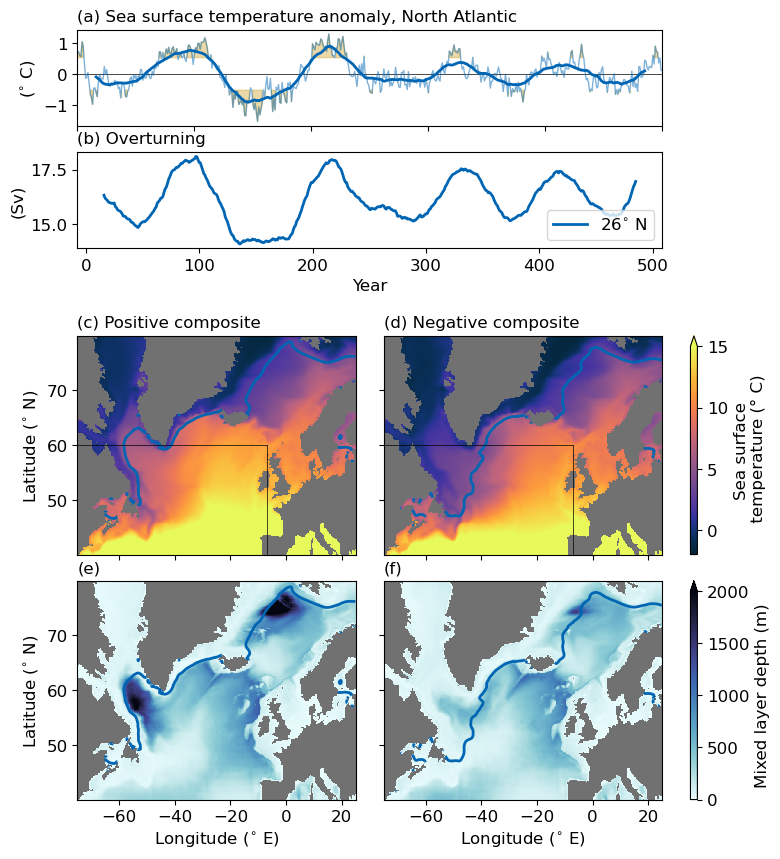

In [275]:
fig = plt.figure(figsize=(8,10))
gs  = gridspec.GridSpec(13, 3, width_ratios=[1, 1, 0.025], hspace=0.75, wspace=0.15)

ax = fig.add_subplot(gs[0:2,0:2])
plt.axhline(y=0, color='k', linewidth=0.5)
plt.plot(year, sst_NA_detrend.mean('xt_ocean').mean('yt_ocean'), color=CLEX_CobaldBlue, zorder=3, linewidth=1, alpha=0.5)
plt.plot(year, data_rolling_mean, color=CLEX_CobaldBlue, zorder=3, linewidth=1, alpha=0.5)
plt.plot(year, data_rolling.mean('xt_ocean').mean('yt_ocean'), linewidth=2, color=CLEX_CobaldBlue)
plt.fill_between(year, data_std, sst_NA_detrend.mean('xt_ocean').mean('yt_ocean'), where=sst_NA_detrend.mean('xt_ocean').mean('yt_ocean')>data_std, alpha=0.5, color=CLEX_Yellow)
plt.fill_between(year, -data_std, sst_NA_detrend.mean('xt_ocean').mean('yt_ocean'), where=sst_NA_detrend.mean('xt_ocean').mean('yt_ocean')<-data_std, alpha=0.5, color=CLEX_Yellow)
plt.title('(a) Sea surface temperature anomaly, North Atlantic', loc='left', fontsize=ft_size)
plt.xlim(0, 500)
plt.xlabel('')
plt.ylabel('($^{\circ}$ C)')
plt.tick_params(labelbottom=False)

ax = fig.add_subplot(gs[2:4,0:2])
plt.plot(year, amoc_26N_rolling, linewidth=2, color=CLEX_CobaldBlue, label='26$^{\circ}$ N')
plt.legend(fontsize=ft_size)
plt.title('(b) Overturning', loc='left', fontsize=ft_size)
plt.xlabel('Year'), plt.ylabel('(Sv)')

ax = fig.add_subplot(gs[5:9,0])
gray_bg.plot(cmap=cm.cm.gray, add_colorbar=False)
sc = sst_pos.plot(vmin=-2, vmax=15, cmap=cm.cm.thermal, add_colorbar=False)
aice_mar_pos.plot.contour(x='xt_ocean', y='yt_ocean', levels=[0.15], colors=CLEX_CobaldBlue, linewidths=2)
plt.plot([-75,-7],[60,60], color='k', linewidth=0.5)
plt.plot([-7,-7],[40,60], color='k', linewidth=0.5)
plt.title(''), plt.title('(c) Positive composite', loc='left', fontsize=ft_size)
plt.tick_params(labelbottom=False)
plt.xlabel(''), plt.ylabel('Latitude ($^{\circ}$ N)');

ax = fig.add_subplot(gs[5:9,1])
gray_bg.plot(cmap=cm.cm.gray, add_colorbar=False)
sst_neg.plot(vmin=-2, vmax=15, cmap=cm.cm.thermal, add_colorbar=False)
aice_mar_neg.plot.contour(x='xt_ocean', y='yt_ocean', levels=[0.15], colors=CLEX_CobaldBlue, linewidths=2)
plt.plot([-75,-7],[60,60], color='k', linewidth=0.5)
plt.plot([-7,-7],[40,60], color='k', linewidth=0.5)
plt.title(''), plt.title('(d) Negative composite', loc='left', fontsize=ft_size)
plt.tick_params(labelbottom=False, labelleft=False)
plt.xlabel(''), plt.ylabel('')

ax = fig.add_subplot(gs[9:,0])
gray_bg.plot(cmap=cm.cm.gray, add_colorbar=False)
SC = mld_mar_pos.plot(cmap=cm.cm.ice_r, add_colorbar=False, vmin=0, vmax=2000)
aice_mar_pos.plot.contour(x='xt_ocean', y='yt_ocean', levels=[0.15], colors=CLEX_CobaldBlue, linewidths=2)
plt.title(''), plt.title('(e)', loc='left', fontsize=ft_size)
plt.xlabel('Longitude ($^{\circ}$ E)'), plt.ylabel('Latitude ($^{\circ}$ N)')

ax = fig.add_subplot(gs[9:,1])
gray_bg.plot(cmap=cm.cm.gray, add_colorbar=False)
mld_mar_neg.plot(cmap=cm.cm.ice_r, add_colorbar=False, vmin=0, vmax=2000)
aice_mar_neg.plot.contour(x='xt_ocean', y='yt_ocean', levels=[0.15], colors=CLEX_CobaldBlue, linewidths=2)
plt.title(''), plt.title('(f)', loc='left', fontsize=ft_size)
plt.xlabel('Longitude ($^{\circ}$ E)'), plt.ylabel('')
plt.tick_params(labelleft=False)


# Colorbar
cbar_ax = fig.add_subplot(gs[5:9, 2])
cbar = plt.colorbar(sc, cax=cbar_ax, label='Sea surface\n temperature (° C)', extend='max')

cbar_ax = fig.add_subplot(gs[9:, 2])
cbar = plt.colorbar(SC, cax=cbar_ax, label='Mixed layer depth (m)', extend='max')

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig10_multidecadal_variability_cz861.png'
    plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight', facecolor='white');


Text(0.5, 1.0, '(f)')

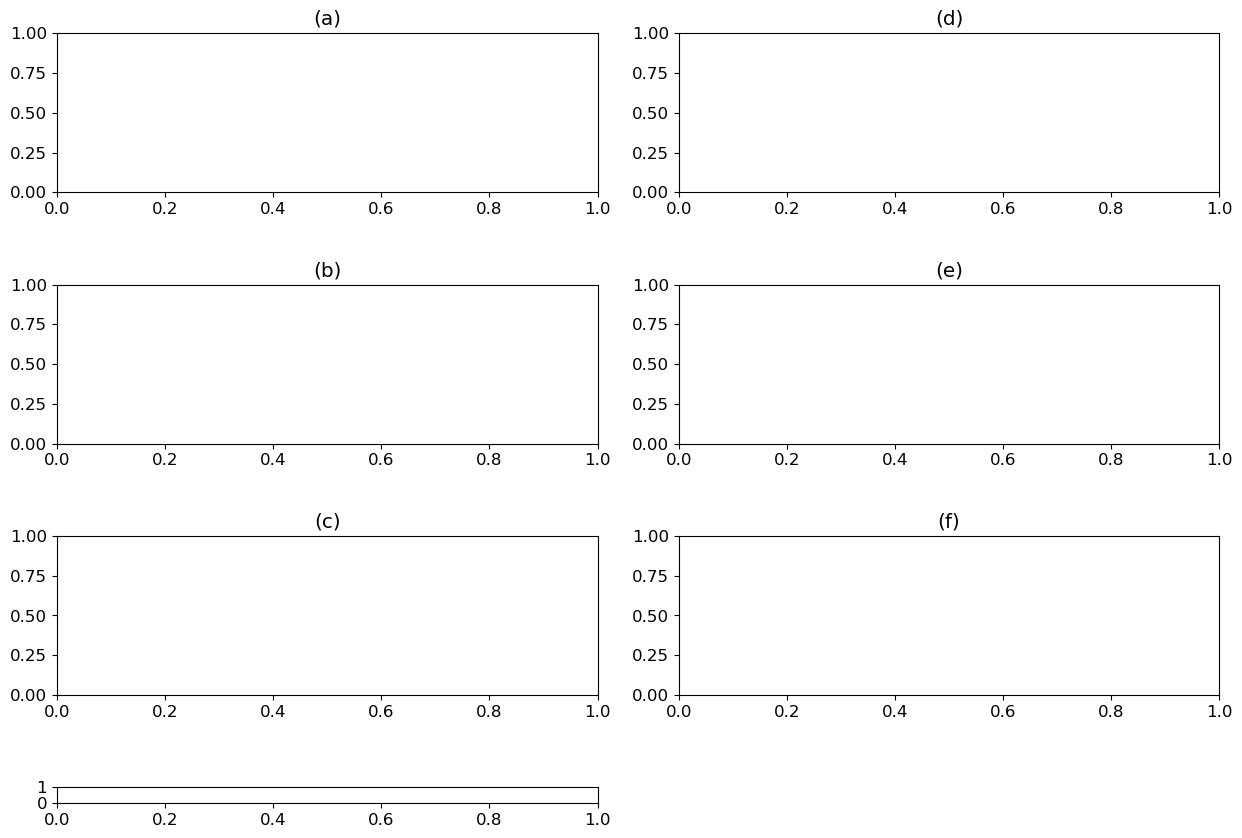

In [258]:
import matplotlib.gridspec as gridspec
ft_size = 12
plt.rcParams.update({'font.size': ft_size})

fig = plt.figure(figsize=(15,10))
gs  = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 0.1], hspace=0.75, wspace=0.15)

# Left side plots
ax = fig.add_subplot(gs[0,0])
plt.title('(a)', fontsize=t_size)

ax = fig.add_subplot(gs[1,0])
plt.title('(b)', fontsize=t_size)

ax = fig.add_subplot(gs[2,0])
plt.title('(c)', fontsize=t_size)

# Colorbar
ax = fig.add_subplot(gs[3,0])

# Right side plots
ax = fig.add_subplot(gs[0,1])
plt.title('(d)', fontsize=t_size)

ax = fig.add_subplot(gs[1,1])
plt.title('(e)', fontsize=t_size)

ax = fig.add_subplot(gs[2,1])
plt.title('(f)', fontsize=t_size)

plt.savefig('Figure_name.png', dpi=300, bbox_inches='tight', facecolor='white')